In [3]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:
class Corona:
    """Retrieve, view and analyze data on the spread of Covid-19"""
    def __init(self):
        self._data = None
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, value):
        self._data = value
    
    def read_worldometer(self):
        """Returns a dataframe with the current Worldometer statistics"""
        response = requests.get('https://www.worldometers.info/coronavirus/')
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', id='main_table_countries')
        data = []
        for row in table.find_all('tr'):
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            data.append([ele for ele in cols if ele])
        return pd.DataFrame(data, columns=['country', 'total', 'new', 'deaths', 'new_deaths', 'recovered', 'active', 'serious', 'cases_per_mil'])
    
    def read_jhu(self):
        "Reads data from Johns Hopkins University Github data. Updated daily."
        urls = {
            'deaths': 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
            'confirmed': 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
            'recovered': 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv',
        }
        results = {}
        for key, url in urls.items():
            results[key] = self._read_file(url, key)
        self._data = (
            results['confirmed'].
            join(results['recovered'].drop(columns=['lat', 'long'])).
            join(results['deaths'].drop(columns=['lat', 'long'])).
            sort_index()
        )

    def do_plot(self, countries, columns, offsets=None):
        """Do a time series plot of the data
        Args:
            countries (list): List of strings with country names that should be ploted (see countries())
            columns (list): List of strings with columns to plot ('confirmed', 'deaths', 'recovered')
            offsets (list): List of integers, same length as countries. For each country, move curve back so many days
                If not supplied, all zeros is used. If shorter than countries, padded with zeros at the end.
        """
        if not offsets:
            offsets = [0 for i in countries]
        if  len(offsets) < len(countries):
            offsets += [0 for i in range(len(countries) - len(offsets))]
        idx = pd.IndexSlice
        plt.figure(figsize=(20,10))
        for i, country in enumerate(countries):
            for col in columns:
                to_plot = self.data.loc[idx[country, :, :], col].groupby(level=[0,2]).sum().shift(-offsets[i])
                plt.plot(
                    to_plot.index.levels[1],
                    to_plot,
                    label=f"{country}({col})")
        plt.legend()
    
    def countries(self, regex=None):
        """Returns a list of countries available. Useful to search for countries if you don't know the exact name
        Args:
            regex (string): If provided, uses it to match case insensitively anywhere in country name
        """
        if regex:
            return [country for country in self.data.index.levels[0] if re.search(regex, country, re.I)]
        else:
            return list(self.data.index.levels[0])
        
    def _read_file(self, filename, label):
        """Read the Johns Hopkins University file format"""
        data = pd.read_csv(filename)
        return (
            data.
            rename(columns={'Province/State': 'province', 'Country/Region': 'country', 'Lat': 'lat', 'Long': 'long'}).
            melt(id_vars=['country', 'province', 'lat', 'long']).
            rename(columns={'variable': 'date', 'value': label}).
            assign(date=lambda x: x.date.astype('datetime64'),
                   province=lambda x: np.where(x.province.isnull(), x.country, x.province)).
            set_index(['country', 'province', 'date'])
        )

In [17]:
corona = Corona()
corona.read_jhu()

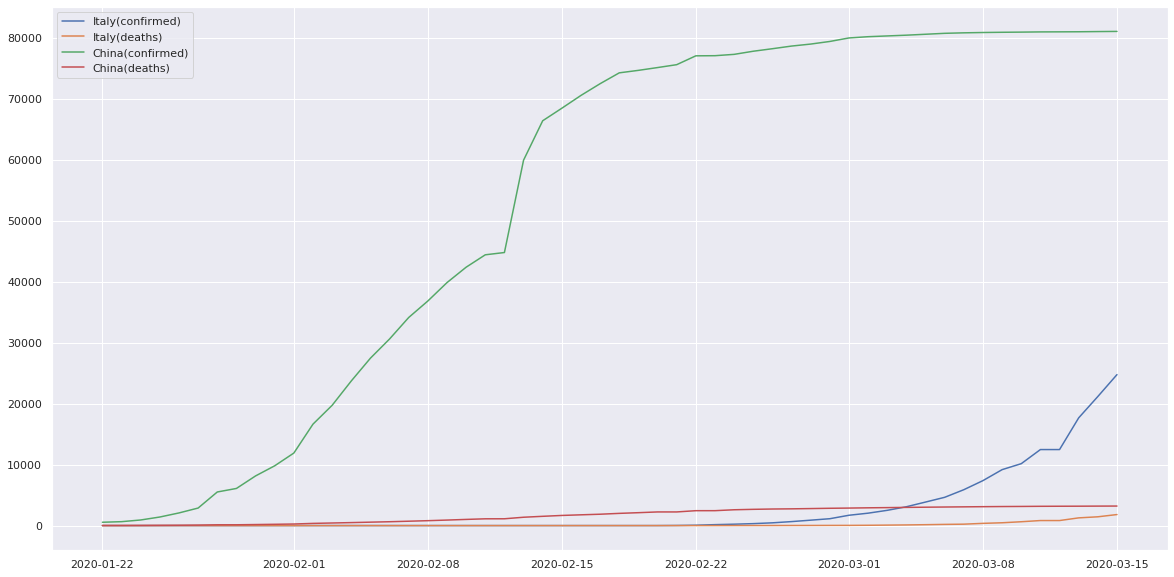

In [18]:
corona.do_plot(['Italy', 'China'], ['confirmed', 'deaths'])

In [19]:
corona.countries('afri')

['Central African Republic', 'South Africa']

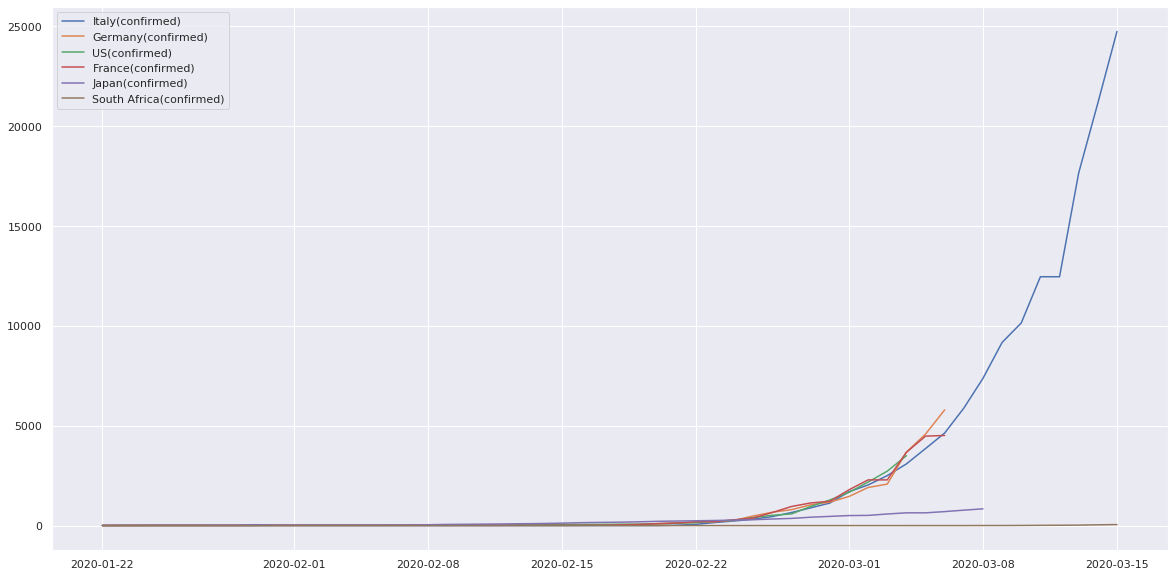

In [9]:
corona.do_plot(['Italy', 'Germany', 'US', 'France', 'Japan', 'South Africa'], ['confirmed'], [0,9,11, 9, 7, 0])